# Early Stage 3 Variable LSTM Model
Purpose:
- experimented with both ANN and LSTM models at the beginning of the term to determine model with best results
- utilizes many-to-one prediction method

Notes:
- based off of the 3 variable model from the Summer 2022 term
- does not implement downsampling

# Installs and Imports

In [1]:
# install external libraries

!pip install wfdb
!pip install tensorflow_addons
!pip install keras-tuner

In [2]:
# import libraries

import keras_tuner as kt
import matplotlib.pyplot as plt
import math
from mpl_toolkits import mplot3d
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
import tensorflow_addons as tfa
import time
import wfdb
from wfdb import processing

# Load and preprocess data

In [16]:
#Need to allow code to access the CSV Dataset. 
#Setting up an environment variable. Will add a readme file in order to show how to use this method.


csv_folder_path = os.environ.get("CSV_Folder_Path")
file_path = os.path.join(csv_folder_path, "uq_vsd_case04_alldata.csv")

# loading data - move file into folders so you don't mount drive every time
df = pd.read_csv(file_path, index_col=False, usecols=['HR', 'SpO2', 'NBP (Mean)', 'ECG'], error_bad_lines=False) # issue with getting time column as index column?
print(df.head(10))
print(df.tail(10))
print(df.shape)

case4_filteredData = df.loc[(~df['HR'].isnull()) & (~df['SpO2'].isnull()) & (~df['NBP (Mean)'].isnull()) & (~df['ECG'].isnull())]
print(case4_filteredData.head(10))
print(case4_filteredData.tail(10))
print(case4_filteredData.shape)

C:\Users\vithu\AppData\Local\Temp\ipykernel_3504\882258653.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(file_path, index_col=False, usecols=['HR', 'SpO2', 'NBP (Mean)', 'ECG'], error_bad_lines=False) # issue with getting time column as index column?


      HR  SpO2  NBP (Mean)    ECG
0  110.0   NaN         NaN  0.225
1  110.0   NaN         NaN  0.180
2  110.0   NaN         NaN  0.165
3  110.0   NaN         NaN  0.170
4  110.0   NaN         NaN  0.175
5  110.0   NaN         NaN  0.175
6  110.0   NaN         NaN  0.175
7  110.0   NaN         NaN  0.185
8  110.0   NaN         NaN  0.175
9  110.0   NaN         NaN  0.170
        HR  SpO2  NBP (Mean)    ECG
876568 NaN   NaN         NaN -0.005
876569 NaN   NaN         NaN -0.005
876570 NaN   NaN         NaN -0.005
876571 NaN   NaN         NaN -0.005
876572 NaN   NaN         NaN -0.005
876573 NaN   NaN         NaN -0.005
876574 NaN   NaN         NaN -0.005
876575 NaN   NaN         NaN -0.005
876576 NaN   NaN         NaN -0.005
876577 NaN   NaN         NaN -0.005
(876578, 4)
         HR  SpO2  NBP (Mean)    ECG
6758  112.0  97.0        93.0 -0.005
6759  112.0  97.0        93.0  0.040
6760  112.0  97.0        93.0  0.080
6761  112.0  97.0        93.0  0.115
6762  112.0  97.0        93.0  0.

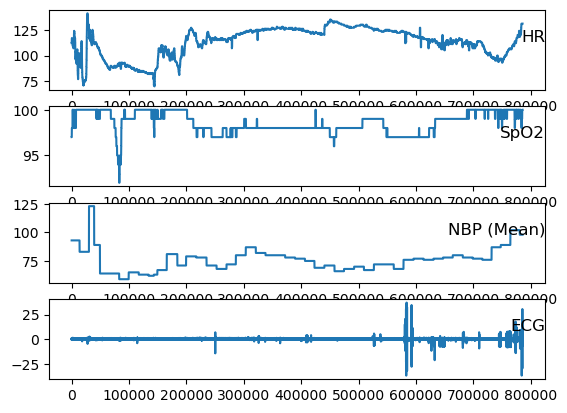

In [4]:
# # plot data
# dataset = pd.read_csv("new_data.csv", index_col=0, header=0)
values = case4_filteredData.values

# specify columns to plot
groups = [0,1,2,3]
i =1
for g in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(values[:, g])
  plt.title(case4_filteredData.columns[g], y=0.5, loc='right')
  i += 1
plt.show()

# Preprocessing/Splitting data

In [5]:
# Function for splitting data into training and test set non-randomly

"""
This functions splits the data into training and test sets.

@param data_df : a Pandas Dataframe that contains the data to be split into training and test sets
@param train_size : a double/float that is within the range of 0 and 1 and represents the fraction of the data to be used for the training set

@returns two Numpy arrays that represent the training and test sets, respectively
"""
def split_data_train_test(data_df, train_size):
  train_df, test_df = data_df[0:round(train_size * len(data_df)), :], data_df[round(train_size * len(data_df)):len(data_df), :]

  return train_df, test_df

# Function for scaling the data
"""
This function takes in the data to be scaled and uses Min-Max Scaling.

@param data : a Numpy array that represents the inputted data to be scaled

@returns the scaled data as a Numpy array, the MinMax scaler object, the scaling factor used, and the minimum value of the original inputted data
"""
def minMaxScaling(data):
  scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0.1, 1))
  scaler.fit(data)

  scaleFactor = scaler.scale_
  data_min = scaler.data_min_
  data_max = scaler.data_max_
  data = scaler.transform(data)

  return data, scaler, scaleFactor, data_min, data_max

"""
This function takes in the data to be scaled and uses Standard Scaling.

@param data : a Numpy array that represents the inputted data to be scaled

@returns the scaled data as a Numpy array, the Standard scaler object, the mean of the original inputted data, and the standard deviation of the original inputted data
"""
def stdScaling(data):
  scaler = sklearn.preprocessing.StandardScaler()
  scaler.fit(data)

  mean = scaler.mean_
  std_dev = scaler.var_ ** 0.5
  data = scaler.transform(data)

  return data, scaler, mean, std_dev

"""
This function plots the inputted data in a 2D scatterplot.

@param xvals : a 1D Numpy array that contains the data to be plotted on the x-axis
@param data : a 1D Numpy array that contains the data to be plotted on the y-axis
@param xVariable : a string that represents the label of the data to be plotted for x-axis
@param yVariable : a string that represents the label of the data to be plotted for y-axis
"""
def plot_data(xvals, data, xVariable, yVariable):
  plt.figure(figsize=(10, 5))
  plt.scatter(xvals, data)
  plt.title("Plot of Data for " + yVariable + ", " + xVariable)
  plt.ylabel(yVariable)
  plt.xlabel(xVariable)
  plt.show()

In [8]:
# Scaling and splitting dataset, using R-Wave Voltages and SpO2 as features
#can use df.shape to see the dimensions of the Dataframe in case you want to check the number of rows and columns 
pd.options.display.max_rows = 1000
print(case4_filteredData.head(20))

case4_filteredData_arr_scaled, minMaxScaler, minMaxScaleFactor, case4_filteredData_min, case4_filteredData_max = minMaxScaling(case4_filteredData)
# combinedData_arr_scaled, stdScaler, combinedData_mean, combinedData_stdDev = stdScaling(combinedData_df) # uncomment this if standard scaling will be used

# Add more columns names if more health variables are added.
case4_filteredData_df_scaled = pd.DataFrame(case4_filteredData_arr_scaled, columns=["SpO2", "HR", "NBP (Mean)", "ECG"])

print()
print(case4_filteredData_df_scaled[0:20])

listOfVariables = ["SpO2", "HR", "NBP (Mean)", "ECG"] # Add more columns names if more health variables are added.
listOfVariables_len = len(listOfVariables) - 1 

data_train, data_test = split_data_train_test(np.array(case4_filteredData_df_scaled[listOfVariables]), train_size=0.8) # scaled data
# data_train, data_test = split_data_train_test(np.array(combinedData_df[listOfVariables]), train_size=0.8) # non-scaled

print("\nOriginal data train and test: ")
print(data_train[0:20])
print(data_test[0:20])

         HR  SpO2  NBP (Mean)    ECG
6758  112.0  97.0        93.0 -0.005
6759  112.0  97.0        93.0  0.040
6760  112.0  97.0        93.0  0.080
6761  112.0  97.0        93.0  0.115
6762  112.0  97.0        93.0  0.140
6763  112.0  97.0        93.0  0.140
6764  112.0  97.0        93.0  0.115
6765  112.0  97.0        93.0  0.055
6766  112.0  97.0        93.0  0.000
6767  112.0  97.0        93.0 -0.035
6768  112.0  97.0        93.0 -0.075
6769  112.0  97.0        93.0 -0.090
6770  112.0  97.0        93.0 -0.095
6771  112.0  97.0        93.0 -0.095
6772  112.0  97.0        93.0 -0.095
6773  112.0  97.0        93.0 -0.095
6774  112.0  97.0        93.0 -0.095
6775  112.0  97.0        93.0 -0.095
6776  112.0  97.0        93.0 -0.055
6777  112.0  97.0        93.0  0.010

        SpO2      HR  NBP (Mean)       ECG
0   0.632394  0.6625    0.578125  0.547530
1   0.632394  0.6625    0.578125  0.548079
2   0.632394  0.6625    0.578125  0.548567
3   0.632394  0.6625    0.578125  0.548994
4   0.6

In [9]:
# Splitting data into previous values and next values

"""
This function splits the training and test sets and turns a certain number of previous values as "features" and the next value as the "target"

@param train_array : a Numpy array with at least 2 columns of the training set values
@param test_array : a Numpy array with at least 2 columns of the test set values
@param numOfPrevValues : an integer that represents the number of previous rows of values to use as features
@param targetIndex : an integer that represents the column number to use for target values

@returns four Numpy arrays for the previous values in the training set, the next 1 value in the training set, the previous values
         in the test set, and the next 1 value in the test set
"""
def splitDataToFeaturesTargetValues(train_array, test_array, numOfPrevValues=2, targetIndex=1):

  prevData_train = [] # contains at least 2 columns of data, like ECG R-Wave Voltages and SpO2
  nextData_train = [] # contains only 1 column of data, like SpO2
  prevData_test = []
  nextData_test = []

  for i in range(numOfPrevValues, len(train_array)):
    prevData_train.append(train_array[i-numOfPrevValues: i])
    nextData_train.append(train_array[i][targetIndex])

  for j in range(numOfPrevValues, len(test_array)):
    prevData_test.append(test_array[j-numOfPrevValues: j])
    nextData_test.append(test_array[j][targetIndex])
  
  prevData_train = np.array(prevData_train)
  nextData_train = np.array(nextData_train).reshape(len(nextData_train), 1)
  prevData_test = np.array(prevData_test)
  nextData_test = np.array(nextData_test).reshape(len(nextData_test), 1)

  return prevData_train, nextData_train, prevData_test, nextData_test

data_train_features, data_train_label, data_test_features, data_test_label = splitDataToFeaturesTargetValues(data_train, data_test, numOfPrevValues=50, targetIndex=2)

print(data_train_features[0:10])
print(data_train_label[0:10])
print(data_test_features[0:10])
print(data_test_label[0:10])

[[[0.63239437 0.6625     0.578125   0.54752999]
  [0.63239437 0.6625     0.578125   0.54807888]
  [0.63239437 0.6625     0.578125   0.54856678]
  ...
  [0.63239437 0.6625     0.578125   0.5464322 ]
  [0.63239437 0.6625     0.578125   0.54667615]
  [0.63239437 0.6625     0.578125   0.54685912]]

 [[0.63239437 0.6625     0.578125   0.54807888]
  [0.63239437 0.6625     0.578125   0.54856678]
  [0.63239437 0.6625     0.578125   0.5489937 ]
  ...
  [0.63239437 0.6625     0.578125   0.54667615]
  [0.63239437 0.6625     0.578125   0.54685912]
  [0.63239437 0.6625     0.578125   0.54716406]]

 [[0.63239437 0.6625     0.578125   0.54856678]
  [0.63239437 0.6625     0.578125   0.5489937 ]
  [0.63239437 0.6625     0.578125   0.54929864]
  ...
  [0.63239437 0.6625     0.578125   0.54685912]
  [0.63239437 0.6625     0.578125   0.54716406]
  [0.63239437 0.6625     0.578125   0.54752999]]

 ...

 [[0.63239437 0.6625     0.578125   0.54826184]
  [0.63239437 0.6625     0.578125   0.54759097]
  [0.63239

# General functions

In [10]:
# Function that makes the loss function plots and linear regression model

"""
This function plots a loss function based on the output of the model fitting.

@param loss_vals : a Tensorflow History object from model fitting, which is used to get the training and validation loss values
@param startRange : an integer that is >= 0, is within the indices of loss_vals, and represents the start indices of the loss values to plot
@param endRange : an integer that is <= len(loss_vals) - 1, is larger than startRange, and represents the end indices of the loss values to plot
"""
def plot_loss(loss_vals, startRange, endRange):
  plt.figure(figsize=(12, 8))
  plt.plot(loss_vals.history['loss'][startRange:endRange], label="Training Loss") 
  plt.plot(loss_vals.history['val_loss'][startRange:endRange], label="Validation Loss") 
  plt.xlabel("Epoch")
  plt.ylabel("Error")
  plt.title("Learning Curve")
  plt.legend()

"""
This function plots the inputted actual and predicted data in a 2D scatterplot.

@param xvals : a 1D Numpy array that contains the data to be plotted on the x-axis
@param actual_data : a 1D Numpy array that contains the actual data to be plotted on the y-axis
@param predicted_data : a 1D Numpy array that contains the predicted data to be plotted on the y-axis
@param xName : a string that represents the x-values and label for the x-axis
@param yName : a string that represents the y-values and label for the y-axis
"""
def plot_model_data(xvals, actual_data, predicted_data, xName, yName):
  plt.figure(figsize=(12, 8))
  plt.scatter(xvals, actual_data, label="Actual Data", color="r")
  plt.plot(xvals, predicted_data, label="Predicted Data", color="black")
  plt.title("Plot of Model Data for " + xName + " Against " + yName)
  plt.xlabel(xName)
  plt.ylabel(yName)
  plt.legend()

"""
This function plots the inputted actual and predicted data in a 3D scatterplot.

@param x_val : a 1D Numpy array that contains the data to be plotted on the x-axis
@param y_val : a 1D Numpy array that contains the data to be plotted on the y-axis
@param actual_data : a 1D Numpy array that contains the actual data to be plotted on the z-axis
@param predicted_data : a 1D Numpy array that contains the predicted data to be plotted on the z-axis
@param xName : a string that represents the x-values and label for the x-axis
@param yName : a string that represents the y-values and label for the y-axis
@param zName : a string that represents the z-values and label for the z-axis
"""
def plot_model_data3D(x_val, y_val, actual_data, predicted_data, xName, yName, zName):
  fig = plt.figure(figsize=(12, 8))

  ax = plt.axes(projection='3d')
  ax.scatter3D(x_val, y_val, actual_data, label='Actual Data', color="red")
  ax.plot3D(x_val, y_val, predicted_data, label='Predicted Data', color="black")

  ax.set_title("Plot of Model Data for " + xName + " And " + yName + " Against " + zName, pad=20)
  ax.set_xlabel(xName)
  ax.set_ylabel(yName)
  ax.set_zlabel(zName)
  ax.legend()

In [11]:
# Functions for getting metrics and plotting predictions

"""
This functions gets and prints the root mean squared error (RMSE) of the targets.

@param test_targets : a Numpy array that represents the actual target values
@param predicted_targets : a Numpy array that represents the predicted target values

@returns the RMSE double/float value
"""
def get_and_print_rmse_for_model(test_targets, predicted_targets):
  rmseMetric = tf.keras.metrics.RootMeanSquaredError()
  rmseMetric.update_state([test_targets], [predicted_targets])
  rmseMetricResult = rmseMetric.result().numpy()

  print("RMSE: " + str(rmseMetricResult))
  return rmseMetricResult

"""
This functions gets and prints the coefficient of determination (R^2) of the targets.

@param test_targets : a Numpy array that represents the actual target values
@param predicted_targets : a Numpy array that represents the predicted target values

@returns the R^2 double/float value
"""
def get_and_print_R2_for_model(test_targets, predicted_targets):
  r2 = sklearn.metrics.r2_score(y_true=test_targets, y_pred=predicted_targets)
  print("R2 (Sklearn): " + str(r2))
  
  return r2

"""
This function uses the mean absolute percentage error (MAPE) to get a percentage error for a regression model. 

Note that if the output is a number above 1 or below 0, usually very big in magnitude, it is because 
some of the numbers in the test_targets are 0 or very close to 0, which gives a division by 0.

@param test_targets : a Numpy array that represents the actual target values
@param predicted_targets : a Numpy array that represents the predicted target values

@returns the MAPE double/float value which represents the decimal form of the percentage, so generally between 0 and 1
"""
def get_and_print_mape_for_model(test_targets, predicted_targets):
  mape = sklearn.metrics.mean_absolute_percentage_error(test_targets, predicted_targets)
  print("MAPE: " + str(mape))

  return mape

"""
This function gets the mean absolute error (MAE) for a regression model. 

Note that if the output is a number below 0, usually very big in magnitude, it is because 
some of the numbers in the test_targets are 0 or very close to 0, which gives a division by 0.

@param test_targets : a Numpy array that represents the actual target values
@param predicted_targets : a Numpy array that represents the predicted target values

@returns the MAPE double/float value, which should be greater than or equal to 0
"""
def get_and_print_mae_for_model(test_targets, predicted_targets):
  mae = sklearn.metrics.mean_absolute_error(test_targets, predicted_targets)
  print("MAE: " + str(mae))

  return mae

"""
This functions plots the actual and predicted values as a line plot.

@param indices : the x-values of the plot as a 1-column Numpy array
@param test_targets : a 1-column Numpy array that represents the actual target values
@param predicted_targets : a 1-column Numpy array that represents the predicted target values
"""
def plot_actual_and_predictions_line(x_val, test_targets, predicted_targets):
  fig = plt.figure(figsize=(12, 8))
  plt.plot(x_val, test_targets, label="Actual Values", c="b")
  plt.plot(x_val, predicted_targets, label="Predicted Values", c="r")

  plt.ylabel("Values")
  plt.title("Plot of Actual and Predicted Values")
  plt.legend()

"""
This functions plots the actual and predicted values as a scatter plot.

@param indices : a 1-column Numpy array that represents x-values of the plot 
@param test_targets : a 1-column Numpy array that represents the actual target values
@param predicted_targets : a 1-column Numpy array that represents the predicted target values
"""
def plot_actual_and_predictions_scatter(x_val, test_targets, predicted_targets):
  fig = plt.figure(figsize=(12, 8))
  plt.scatter(x_val, test_targets, label="Actual Values", c="b")
  plt.scatter(x_val, predicted_targets, label="Predicted Values", c="r")

  plt.ylabel("Value")
  plt.title("Plot of Actual and Predicted Values")
  plt.legend()

In [13]:
# Functions for making different ML models

# Function for making LSTM model with a certain amount of layers
"""
This function makes a custom LSTM neural network model.

@param train_features : a Numpy array that represents the training data features
@param train_labels : a Numpy array that represents the training data targets
@param numOfUnits : a list that contains the number of units for each layer, which could be customized by providing different integers in the desired order. 
                    The size of the list should either be equal to 1 or numOfLayers. If size = 1, then all layers will have that number of units in the list.
                    (eg. [4, 8, 16] if numOfLayers = 3, or [4] for any value of numOfLayers)
@param numOfLayers : an integer that represents the desired of layers to add to the model 
@param epochNum : the number of iterations/epochs for running the model
@param learning_rate : a double/float that represents the learning rate of the model

@returns the LSTM neural network TensorFlow model and the result from fitting the model

"""
def make_custom_LSTM(train_features, train_labels, numOfUnits=[4], numOfLayers=1, batchNum=None, epochNum=100, learning_rate=0.01, min_delta=0.0007):
  callback_valLoss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, min_delta=min_delta, mode='min', verbose=1)
  callback_trainLoss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1, min_delta=min_delta, mode='min', verbose=1)
  
  lstm_model = tf.keras.Sequential()
  limit = numOfLayers

  if (len(numOfUnits) != numOfLayers) and (len(numOfUnits) != 1):
    raise Exception("Invalid input for numOfUnits.")

  lstm_model.add(tf.keras.layers.Normalization(axis=-1))
  
  for i in range(0, limit):
    if len(numOfUnits) is numOfLayers:
      numUnits = numOfUnits[i]
    
    else:
      numUnits = numOfUnits[0]

    lstm_model.add(tf.keras.layers.LSTM(units=numUnits, return_sequences=True))
  
  lstm_model.add(tf.keras.layers.Dense(1)) # for 1 value output
  lstm_model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                    loss='mean_squared_error', metrics=['accuracy'])
  
  lstm_model_fit = lstm_model.fit(train_features, train_labels, batch_size=batchNum, epochs=epochNum, validation_split=0.3, callbacks=[callback_valLoss, callback_trainLoss])

  return lstm_model, lstm_model_fit

# LSTM Model - Predicting HR

In [ ]:
# Running the models to predict SpO2 - LSTM

data_train_features, data_train_label, data_test_features, data_test_label = splitDataToFeaturesTargetValues(data_train, data_test, numOfPrevValues=2, targetIndex=0)
print(data_train_features.shape)

batch_num = int(len(data_train_label) / 1550)
# batch_num = None
epochNum = 1000
learn_rate = 0.0001
numOfUnits_list = [512]

print("\nBatch Size: " + str(batch_num) + "\n")

lstm_model_spo2, lstm_model_spo2_fit = make_custom_LSTM(data_train_features, data_train_label, numOfUnits=numOfUnits_list, batchNum=batch_num,
                                              numOfLayers=6, epochNum=epochNum, learning_rate=learn_rate, min_delta=0.0001)

plot_loss(lstm_model_spo2_fit, 0, epochNum)
lstm_model_spo2.summary()

(628680, 2, 4)

Batch Size: 405

Epoch 1/1000
1087/1087 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 8.4190e-04

In [ ]:
# Predicting with the model for HR - training set - LSTM

print("\nFor training set:\n")
predictions = lstm_model_spo2.predict(data_train_features)

predictions = predictions.reshape(data_train_features.shape[0], data_train_features.shape[1]) # current shape is (length, numOfPrevValues, 1)
predictions = predictions[:, 0] # getting values for the next time step (t) and not (t+1, t+2, or t+3)
predictions = np.reshape(predictions, newshape=(len(predictions), 1))

get_and_print_rmse_for_model(data_train_label, predictions)
get_and_print_R2_for_model(data_train_label, predictions)
get_and_print_mae_for_model(data_train_label, predictions)
get_and_print_mape_for_model(data_train_label, predictions)

print("\nAfter reversing the scaling:\n")

# For if MinMaxScaler was used; change the column number/index to get the values for other health variables
predictions_reversed = ((predictions - 0.1) / (1 - 0.1)) * (case4_filteredData_max[0] - case4_filteredData_min[0]) + case4_filteredData_min[0]
data_train_label_reversed = ((data_train_label - 0.1) / (1 - 0.1)) * (case4_filteredData_max[0] - case4_filteredData_min[0]) + case4_filteredData_min[0]
# data_train_features_reversed = ((data_train_features - 0.1) / (1 - 0.1)) * (combinedData_max[0] - combinedData_min[0]) + combinedData_min[0]

# For if standard scaling was used; change the column number/index to get the values for other health variables
# predictions_reversed = predictions * combinedData_stdDev[2] + combinedData_mean[2]
# data_train_label_reversed = data_train_label * combinedData_stdDev[2] + combinedData_mean[2]
# data_train_features_reversed = data_train_features * combinedData_stdDev[0] + combinedData_mean[0]

get_and_print_rmse_for_model(data_train_label_reversed, predictions_reversed)
get_and_print_R2_for_model(data_train_label_reversed, predictions_reversed)
get_and_print_mae_for_model(data_train_label_reversed, predictions_reversed)
get_and_print_mape_for_model(data_train_label_reversed, predictions_reversed)

plot_actual_and_predictions_line(np.arange(0, len(data_train_label)), data_train_label, predictions)
plot_actual_and_predictions_scatter(np.arange(0, len(data_train_label)), data_train_label, predictions)

In [ ]:
# Predicting with the model for HR- test set - LSTM

print("\nFor testing set:\n")
predictions = lstm_model_spo2.predict(data_test_features)

predictions = predictions.reshape(data_test_features.shape[0], data_test_features.shape[1]) # current shape is (length, numOfPrevValues, 1)
predictions = predictions[:, 0] # getting values for the next time step (t) and not (t+1, t+2, or t+3)
predictions = np.reshape(predictions, newshape=(len(predictions), 1))

get_and_print_rmse_for_model(data_test_label, predictions)
get_and_print_R2_for_model(data_test_label, predictions)
get_and_print_mae_for_model(data_test_label, predictions)
get_and_print_mape_for_model(data_test_label, predictions)

plot_actual_and_predictions_line(np.arange(0, len(data_test_label)), data_test_label, predictions)
plot_actual_and_predictions_scatter(np.arange(0, len(data_test_label)), data_test_label, predictions)

# this function won't plot properly if there are more than 3 variables in the model
# plot_model_data3D(data_test_features[:, :, 0][:, 0].flatten(), data_test_features[:, :, 1][:, 0].flatten(), data_test_features[:, :, 2][:, 0].flatten(),
                  # predictions.flatten(), "SpO2", "HR", "NBP (Mean)", "ECG")

# column 2 for SpO2 values, 0 for ECG R-Wave Voltages; change the column number/index to get the values for other health variables
print("\nAfter reversing the scaling: \n")

# For if MinMaxScaler was used
predictions_reversed = ((predictions - 0.1) / (1 - 0.1)) * (case4_filteredData_max[0] - case4_filteredData_min[0]) + case4_filteredData_min[0]
data_test_label_reversed = ((data_test_label - 0.1) / (1 - 0.1)) * (case4_filteredData_max[0] - case4_filteredData_min[0]) + case4_filteredData_min[0]
# data_test_features_reversed = ((data_test_features - 0.1) / (1 - 0.1)) * (combinedData_max[0] - combinedData_min[0]) + combinedData_min[0]

# For if standard scaling was used; change the column number/index to get the values for other health variables
# predictions_reversed = predictions * combinedData_stdDev[2] + combinedData_mean[2]
# data_test_label_reversed = data_test_label * combinedData_stdDev[2] + combinedData_mean[2]
# data_test_features_reversed = data_test_features * combinedData_stdDev[0] + combinedData_mean[0]

get_and_print_rmse_for_model(data_test_label_reversed, predictions_reversed)
get_and_print_R2_for_model(data_test_label_reversed, predictions_reversed)
get_and_print_mae_for_model(data_test_label_reversed, predictions_reversed)
get_and_print_mape_for_model(data_test_label_reversed, predictions_reversed)

print("\nRange of Values: " + str(case4_filteredData_min[2]) + " to " + str(case4_filteredData_max[2]) + "\n")